In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, silhouette_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

In [2]:
df_climate = pd.read_csv('climate_data.csv')
df_station = pd.read_csv('station_detail.csv')
df_province = pd.read_csv('province_detail.csv')
df_merged = pd.merge(df_climate, df_station, on='station_id', how='left')
df_full = pd.merge(df_merged, df_province, on='province_id', how='left')

In [3]:
df_full.head()

,date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,station_id,station_name,region_name,latitude,longitude,region_id,province_id,province_name
0,01-01-2010,21.4,30.2,27.1,82.0,9.0,0.5,7.0,90.0,5.0,E,96001,Stasiun Meteorologi Maimun Saleh,Kota Sabang,5.87655,95.33785,20,1,Nanggroe Aceh Darussalam
1,02-01-2010,21.0,29.6,25.7,95.0,24.0,0.2,6.0,90.0,4.0,E,96001,Stasiun Meteorologi Maimun Saleh,Kota Sabang,5.87655,95.33785,20,1,Nanggroe Aceh Darussalam
2,03-01-2010,20.2,26.8,24.5,98.0,63.0,0.0,5.0,90.0,4.0,E,96001,Stasiun Meteorologi Maimun Saleh,Kota Sabang,5.87655,95.33785,20,1,Nanggroe Aceh Darussalam
3,04-01-2010,21.0,29.2,25.8,90.0,0.0,0.1,4.0,225.0,3.0,SW,96001,Stasiun Meteorologi Maimun Saleh,Kota Sabang,5.87655,95.33785,20,1,Nanggroe Aceh Darussalam
4,05-01-2010,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN,NaN,NaN,96001,Stasiun Meteorologi Maimun Saleh,Kota Sabang,5.87655,95.33785,20,1,Nanggroe Aceh Darussalam


In [4]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%d-%m-%Y')
df_full['RR'] = df_full['RR'].fillna(0)
#df_full['Tavg'] = df_full.groupby('station_id')['Tavg'].transform(lambda x: x.fillna(x.mean()))
df_full['Tx'] = df_full.groupby('station_id')['Tx'].transform(lambda x: x.fillna(x.mean()))
df_full.dropna(subset=['Tavg', 'Tx'], inplace=True)
df_full.sort_values(by=['station_id', 'date'], inplace=True)

In [5]:
df_full['is_dry_day'] = (df_full['RR'] == 0).astype(int)
df_full['is_hot_day'] = (df_full['Tx'] > 35).astype(int)
def calculate_max_streak(series):
    max_streak = 0; current_streak = 0
    for value in series:
        if value == 1: current_streak += 1
        else: max_streak = max(max_streak, current_streak); current_streak = 0
    max_streak = max(max_streak, current_streak)
    return max_streak

# Membuat profil stasiun HANYA dengan fitur beruntun yang kuat
station_profile = df_full.groupby('station_id').agg(
    max_consecutive_dry_days=('is_dry_day', calculate_max_streak),
    max_consecutive_hot_days=('is_hot_day', calculate_max_streak)
).reset_index()


In [6]:
features_for_clustering = station_profile.drop(columns=['station_id'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_clustering)


In [7]:
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_scaled)


In [8]:
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_pca)
    if len(np.unique(labels)) > 1: # Silhouette score butuh > 1 klaster
        silhouette_scores.append(silhouette_score(features_pca, labels))
    else:
        silhouette_scores.append(-1)

In [9]:
OPTIMAL_K = K_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
station_profile['cluster'] = kmeans.fit_predict(features_pca)
final_silhouette_score = silhouette_score(features_pca, station_profile['cluster'])

print(f"Jumlah klaster optimal: {OPTIMAL_K}")
print(f"Silhouette Score (dengan Fitur Canggih): {final_silhouette_score:.4f}")


Jumlah klaster optimal: 2
Silhouette Score (dengan Fitur Canggih): 0.6821


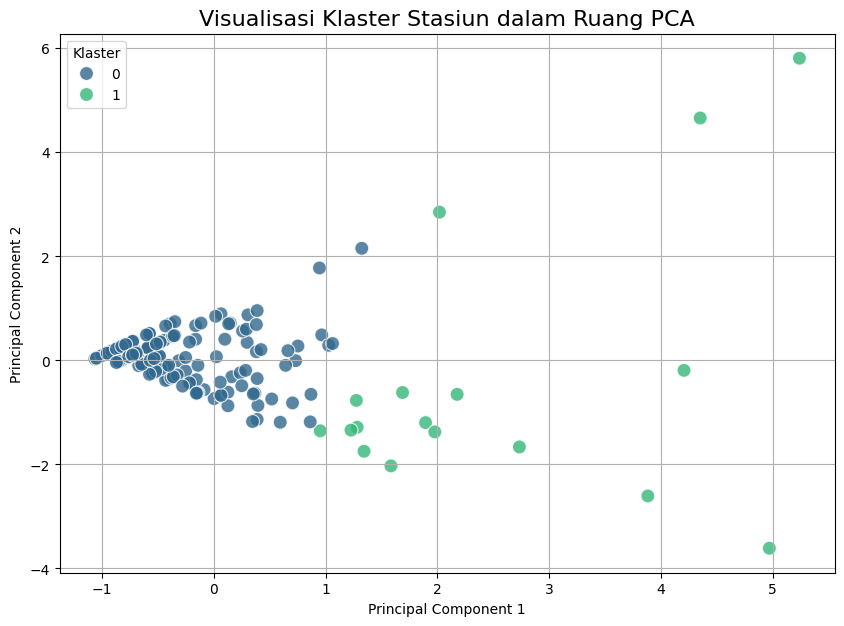

In [10]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=station_profile['cluster'], palette='viridis', s=100, alpha=0.8)
plt.title('Visualisasi Klaster Stasiun dalam Ruang PCA', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Klaster')
plt.grid(True)
plt.show()

In [11]:
cluster_analysis = station_profile.groupby('cluster').mean()
# Label rawan diberikan ke klaster dengan max_consecutive_dry_days tertinggi
rawan_cluster_id = cluster_analysis['max_consecutive_dry_days'].idxmax()
station_profile['rawan_krisis'] = (station_profile['cluster'] == rawan_cluster_id).astype(int)
print(f"Klaster Rawan Krisis Air adalah: Klaster {rawan_cluster_id}")


Klaster Rawan Krisis Air adalah: Klaster 1


In [12]:
province_risk = pd.merge(station_profile, df_station[['station_id', 'province_id']], on='station_id')
province_risk = pd.merge(province_risk, df_province, on='province_id')
province_risk_summary = province_risk.groupby('province_name')['rawan_krisis'].mean().reset_index()
province_risk_summary.rename(columns={'rawan_krisis': 'tingkat_risiko'}, inplace=True)

geojson_url = "https://raw.githubusercontent.com/ans-4175/peta-indonesia-geojson/master/indonesia-prov.geojson"
try:
    gdf = gpd.read_file(geojson_url)
    print("Data GeoJSON peta provinsi berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat GeoJSON dari URL. Error: {e}")
    exit()

Data GeoJSON peta provinsi berhasil dimuat.


In [13]:
def standardize_name(name):
    name = name.lower()
    name = re.sub(r'\.', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name
special_mapping = {
    'nanggroe aceh darussalam': 'di aceh', 'kep bangka belitung': 'bangka belitung',
    'di yogyakarta': 'daerah istimewa yogyakarta', 'dki jakarta': 'dki jakarta',
    'kep riau': 'kepulauan riau', 'nusa tenggara barat': 'nusatenggara barat'
}
province_risk_summary['join_key'] = province_risk_summary['province_name'].apply(standardize_name).replace(special_mapping)
gdf['join_key'] = gdf['Propinsi'].apply(standardize_name).replace(special_mapping)
merged_gdf = gdf.merge(province_risk_summary, on='join_key', how='left')

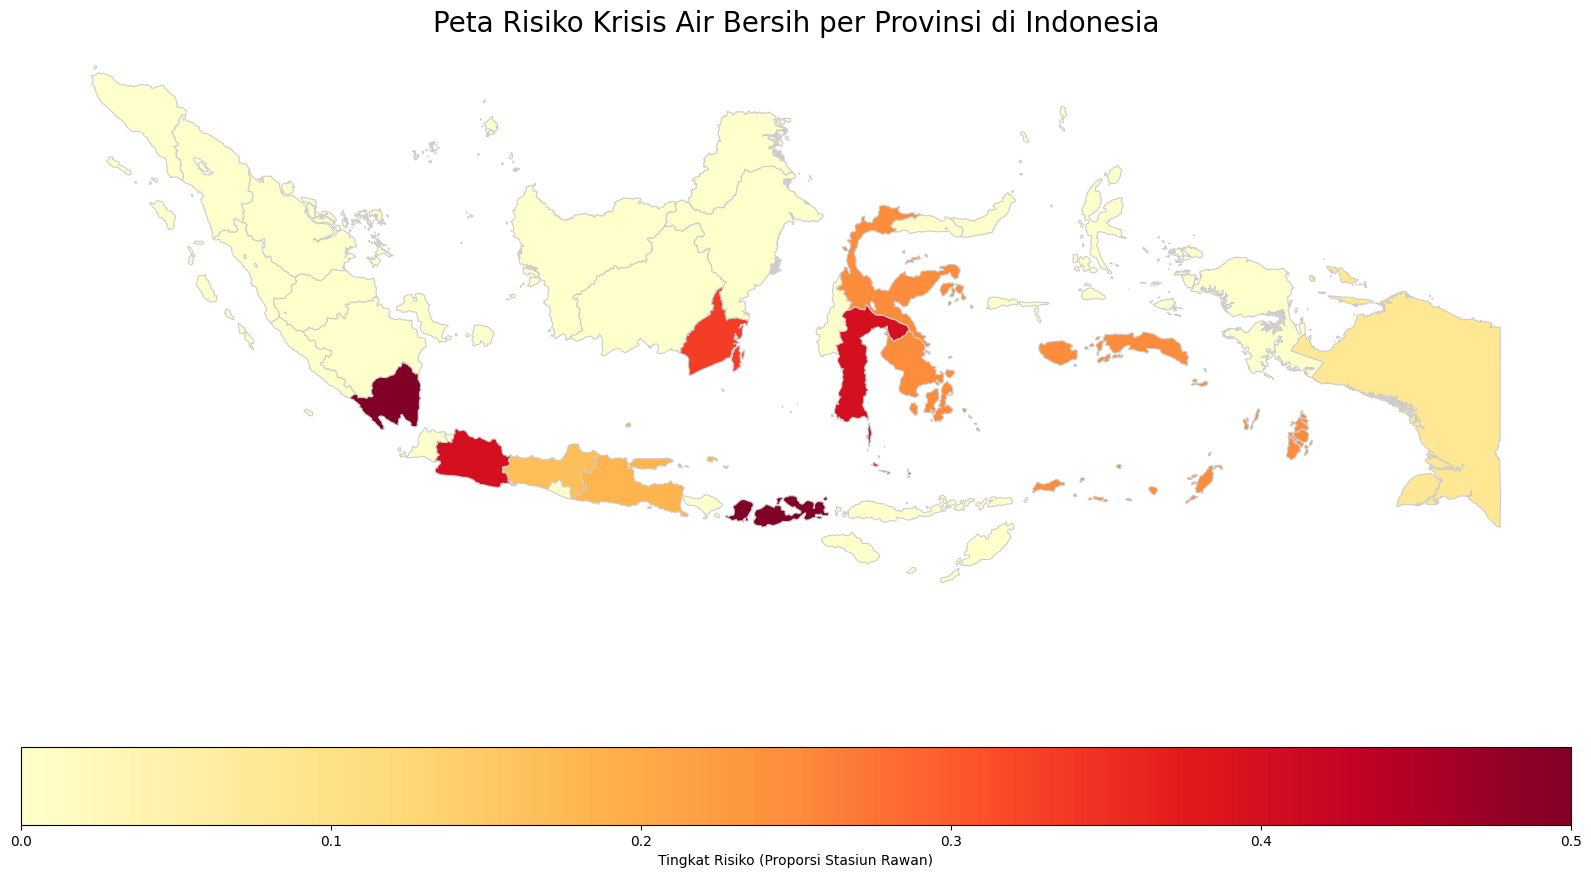

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.set_title('Peta Risiko Krisis Air Bersih per Provinsi di Indonesia', fontdict={'fontsize': '20', 'fontweight': '3'})
ax.axis('off')

provinces_without_data = merged_gdf[merged_gdf['tingkat_risiko'].isna()]
provinces_with_data = merged_gdf.dropna(subset=['tingkat_risiko'])

# Plot provinsi tanpa data (abu-abu) HANYA JIKA ADA
if not provinces_without_data.empty:
    provinces_without_data.plot(color='lightgrey', linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.text(0.05, 0.1, 'Wilayah abu-abu: Data Tidak Tersedia', transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Plot provinsi dengan data (berwarna) HANYA JIKA ADA
if not provinces_with_data.empty:
    provinces_with_data.plot(column='tingkat_risiko', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8',
                             legend=True, legend_kwds={'label': "Tingkat Risiko (Proporsi Stasiun Rawan)",
                                                        'orientation': "horizontal"})
else:
    print("\nPeringatan: Tidak ada data risiko yang dapat diplot di peta setelah proses merge.")

plt.show()

In [16]:
X_profile = station_profile.drop(columns=['station_id', 'cluster', 'rawan_krisis'])
y_profile = station_profile['rawan_krisis']

In [17]:
X_train_prof, X_test_prof, y_train_prof, y_test_prof = train_test_split(X_profile, y_profile, test_size=0.3, random_state=42, stratify=y_profile)
print(f"Melatih model pada {len(X_train_prof)} stasiun dan menguji pada {len(X_test_prof)} stasiun.")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_prof, y_train_prof)
y_pred_prof = rf_model.predict(X_test_prof)
y_pred_proba_prof = rf_model.predict_proba(X_test_prof)[:, 1]


Melatih model pada 116 stasiun dan menguji pada 51 stasiun.


Akurasi: 0.9804
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      0.80      0.89         5

    accuracy                           0.98        51
   macro avg       0.99      0.90      0.94        51
weighted avg       0.98      0.98      0.98        51



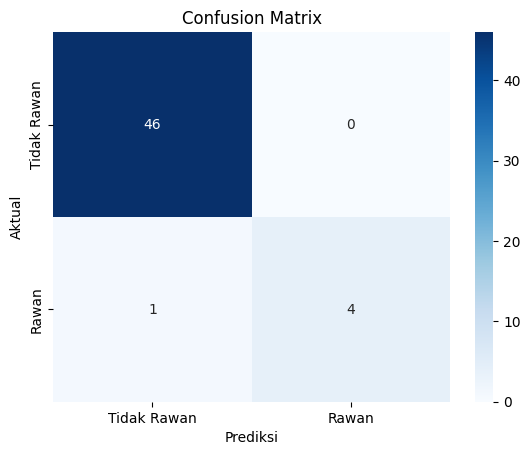

In [18]:
print(f"Akurasi: {accuracy_score(y_test_prof, y_pred_prof):.4f}")
print(classification_report(y_test_prof, y_pred_prof))
cm = confusion_matrix(y_test_prof, y_pred_prof)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Rawan', 'Rawan'], yticklabels=['Tidak Rawan', 'Rawan'])
plt.xlabel('Prediksi'); plt.ylabel('Aktual'); plt.title('Confusion Matrix'); plt.show()

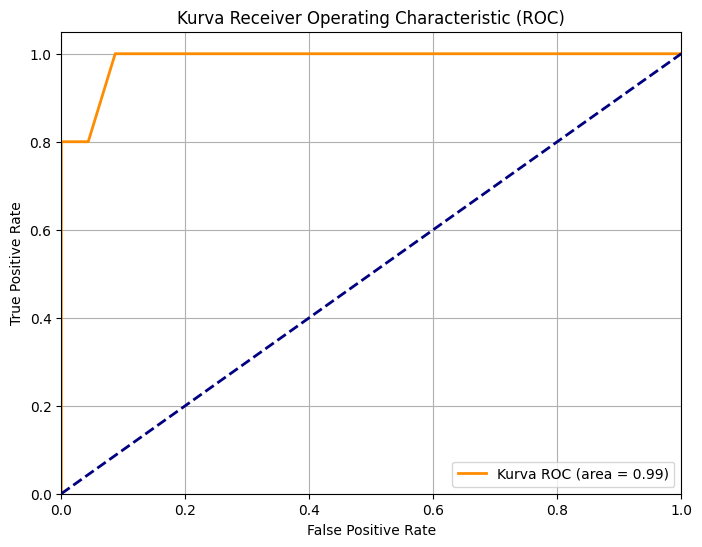

In [19]:
fpr, tpr, _ = roc_curve(y_test_prof, y_pred_proba_prof) # Menggunakan variabel yang benar
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Kurva Receiver Operating Characteristic (ROC)'); plt.legend(loc="lower right"); plt.grid(True)
plt.show()

In [20]:
final_labeled_data_path = 'labeled_station_profiles.csv'
station_profile.to_csv(final_labeled_data_path, index=False)

In [21]:
scaler_path = 'minmax_scaler.joblib'
joblib.dump(scaler, scaler_path)

['minmax_scaler.joblib']

In [22]:
pca_path = 'pca_model.joblib'
joblib.dump(pca, pca_path)
print(f"Model PCA disimpan di: {pca_path}")

Model PCA disimpan di: pca_model.joblib


In [23]:
kmeans_path = 'kmeans_model.joblib'
joblib.dump(kmeans, kmeans_path)
print(f"Model KMeans disimpan di: {kmeans_path}")

Model KMeans disimpan di: kmeans_model.joblib


In [24]:
classifier_path = 'risk_classifier_model.joblib'
joblib.dump(rf_model, classifier_path)
print(f"Model Klasifikasi disimpan di: {classifier_path}")

Model Klasifikasi disimpan di: risk_classifier_model.joblib
